In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
# import the datasets
df = pd.read_csv('./ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**Dataset Info**

In [110]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [111]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In our dataset here, we don't have NULL data.

Now, before conducting AB Testing, I will review some steps to create AB test:
- Design our experiment
- Collect and prepare the dataset
- Visualize the result
- Test the hypothesis
- Draw the conclusions

**The Problem**

- Current conversion rate = 13%

- Expected conversion rate with new version = 15%

**1. Design the experiment**

To conduct an AB test, we need to have two groups: control group and treatment group.
- Control group: who will see the old version of a product.
- Treatment: who will see the new version.

Some metrics we need to use: 
- alpha (α): 0.05
- Confidence Interval: we will choose 95%
- P-value:
- Conversion rate: 

Because in herem we don't know what version is better, then we will choose a two-tailed test.
It means:
- Hₒ: p = pₒ
- Hₐ: p ≠ pₒ

where pₒ, p are the conversion rate of old and new version.

**Choosing sample size**

In [113]:
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

In [114]:
# Calculating effect size based on our expected rates

effect_size = sms.proportion_effectsize(0.13,0.15)

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio= 1
)

# Calculating sample size needed
required_n = ceil(required_n)

print(required_n)


4720


So, it means that we will need 4720 users for each group ( control group & treatment group )

**2. Collect and prepare the data**

In [115]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [116]:
pd.crosstab(df['group'],df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [117]:
# remove user who appear multiple times on dataset

session_counts = df['user_id'].value_counts(ascending=False)

users_to_drop = session_counts[session_counts>1].index

df_new = df[~df['user_id'].isin(users_to_drop)]

In [118]:
df_new.shape

(286690, 5)

In [119]:
# Sampling for control group and treatment group

control_sample = df_new[df_new['group']=='control'].sample(n=required_n, random_state=22)

treatment_sample = df_new[df_new['group']=='treatment'].sample(n=required_n, random_state=22)

#Concat two group_sample to get the new dataset
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


**3.Visulaize the result**

In [120]:
# Calculating the standard deviation
std_p = lambda x: np.std(x, ddof=0)

# Calculating the standard error
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rate =  ab_test.groupby('group')['converted'].agg([np.mean, std_p, se_p])
conversion_rate.columns = ['conversion_rate','std_deviation','std_error']

conversion_rate.style.format('.{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,.0.123,.0.329,.0.005
treatment,.0.126,.0.331,.0.005


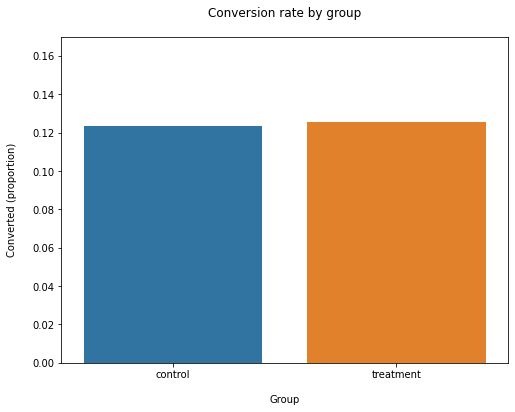

In [121]:
# plot the data

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0,0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

**4. Testing the hypothesis**

In [122]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

con_results = ab_test[ab_test['group']=='control']['converted']
treat_results = ab_test[ab_test['group']=='treatment']['converted']

n_con = con_results.count()
n_treat = treat_results.count()

successes = [con_results.sum(), treat_results.sum()]

nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f},{upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114,0.133]
ci 95% for treatment group: [0.116, 0.135]


**5. Draw conclusions**

Because p-value = 0.732 > 0.05, it means that we can reject the NULL Hypothesis. Thus, we cannot conclude that our new version will be better than our old version. 

Moreover, we can see that the CI for treatment group is [0.116, 0.135], it is less than 15%, so we cannot conclude that New version is better.

So, creating this new version is not a great idea.